In [1]:
"""
Prediction file: Based on the trained neural network,see the performace on the testing set
Mapping Seed-> Sim (Fig 2)

General workflow
Load test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> 
Decode into higher dimensional representation using SD VAE-> Display 


"""

'\nPrediction file: Based on the trained neural network,see the performace on the testing set\nMapping Seed-> Sim (Fig 2)\n\nGeneral workflow\nLoad test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> \nDecode into higher dimensional representation using SD VAE-> Display \n\n\n'

In [ ]:
# import libraries 

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


from models.vae import decode_img
from models.dilResNet import PDEArenaDilatedResNet
import pickle

from utils.config import SIMULATION_TEST_INPUT_FOLDER, SIMULATION_TEST_OUTPUT_FOLDER
from utils.config import SIMULATION_TEST_INPUT_FOLDER_2,SIMULATION_TEST_OUTPUT_FOLDER_2
from utils.config import LATENT_OUTPUT_SAVED,MODEL_DILRESNET_FIG2 

from utils.display import display_predicted_images, display_images_with_ssim, display_predicted_images_5X
from utils.preprocess import preprocess_simulation_input_data,preprocess_simulation_output_data,scale_latents


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-10-22 13:37:59,494] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# prediction from testing dataset

'''
Loading test data for model testing

'''

path_output=SIMULATION_TEST_OUTPUT_FOLDER
path_output_2=SIMULATION_TEST_OUTPUT_FOLDER_2
path_input=SIMULATION_TEST_INPUT_FOLDER
path_input_2=SIMULATION_TEST_INPUT_FOLDER_2

# output data
start_index = 0  
end_index = 8   
output_data=preprocess_simulation_output_data(path_output, start_index, end_index)


## add some of the images from the main dataset that hasn't been used to train the network 

start_index = 70000  
end_index = 70025 
output_data_2=preprocess_simulation_output_data(path_output_2, start_index, end_index)

output_data.extend(output_data_2)
# input data

start_index = 0  
end_index = 8   
input_data=preprocess_simulation_input_data(path_input, start_index, end_index)


start_index = 70000  
end_index = 70025 
input_data_2=preprocess_simulation_input_data(path_input_2, start_index, end_index)

input_data.extend(input_data_2)

X=output_data
y=input_data


# size of input data is 32x32 and output data is 256x256
X=(np.array(X).reshape(-1,1,256,256)) #/255.0  # last one is grayscale first minus one is all x
y=(np.array(y).reshape(-1,1,32,32)) #/255.0

# normalizing images here to be bw 0 and 1 

X=X/255.0 
y=y/255.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)

y3=y.repeat(1, 3, 1, 1)
y4=y.repeat(1, 4, 1, 1)


In [4]:
'''
Defining dilResNet model for loading model weights
'''

model = PDEArenaDilatedResNet(
    in_channels=3,               # Input channels
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)


(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


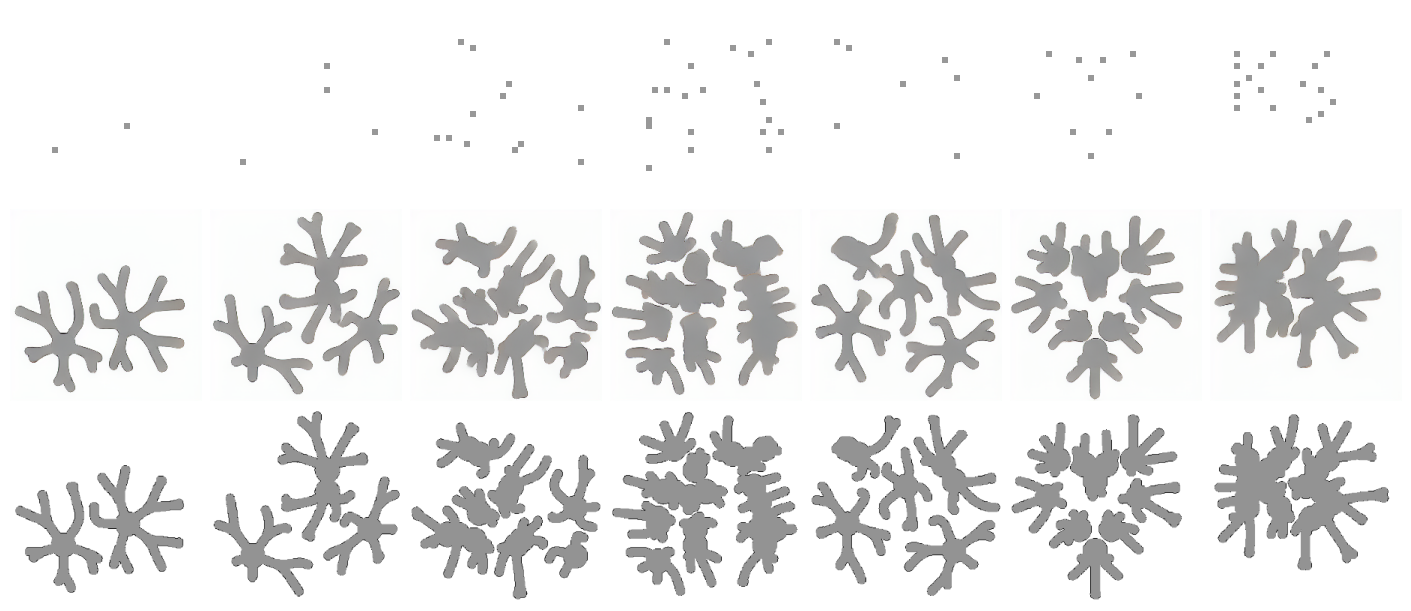

In [5]:
'''
Define pre-trained SD VAE for decoding orginal predicted patterns from the latent predicted patterns
dilResnet will predict latent representation of patterns 

'''

# load trained model weights
model.load_state_dict(torch.load(MODEL_DILRESNET_FIG2))
model.to(device)

model.eval()
with torch.no_grad():
    predicted_latents=model(y3[:,:,:,:].to(device))  #y3 is the input seed with 3 channels for the UNET 


predicted_latents_rescaled=predicted_latents

# use the vae decoder to convert the encoded images to final patterns

pred_images=decode_img(predicted_latents_rescaled)


selected_indices=[14,18,9,10,4,5,2] 
# Display samples from train dataset
order=[0,2,1]

# process images as gray for display

# y3_gray=process_tensor_batch_with_grayfordisplay(y3,img_length=32,img_width=32,img_type='seed')
# X_gray=process_tensor_batch_with_grayfordisplay(X,img_length=256,img_width=256,img_type='sim')
# pred_images_gray=process_tensor_batch_with_grayfordisplay(pred_images,img_length=256,img_width=256,img_type='sim')


display_predicted_images(y3[selected_indices,:,:,:],X[selected_indices,:,:,:], pred_images[selected_indices,:,:,:] ,len(selected_indices), order=order)   #

Sample 0: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 5: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 6: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 7: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 8: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)


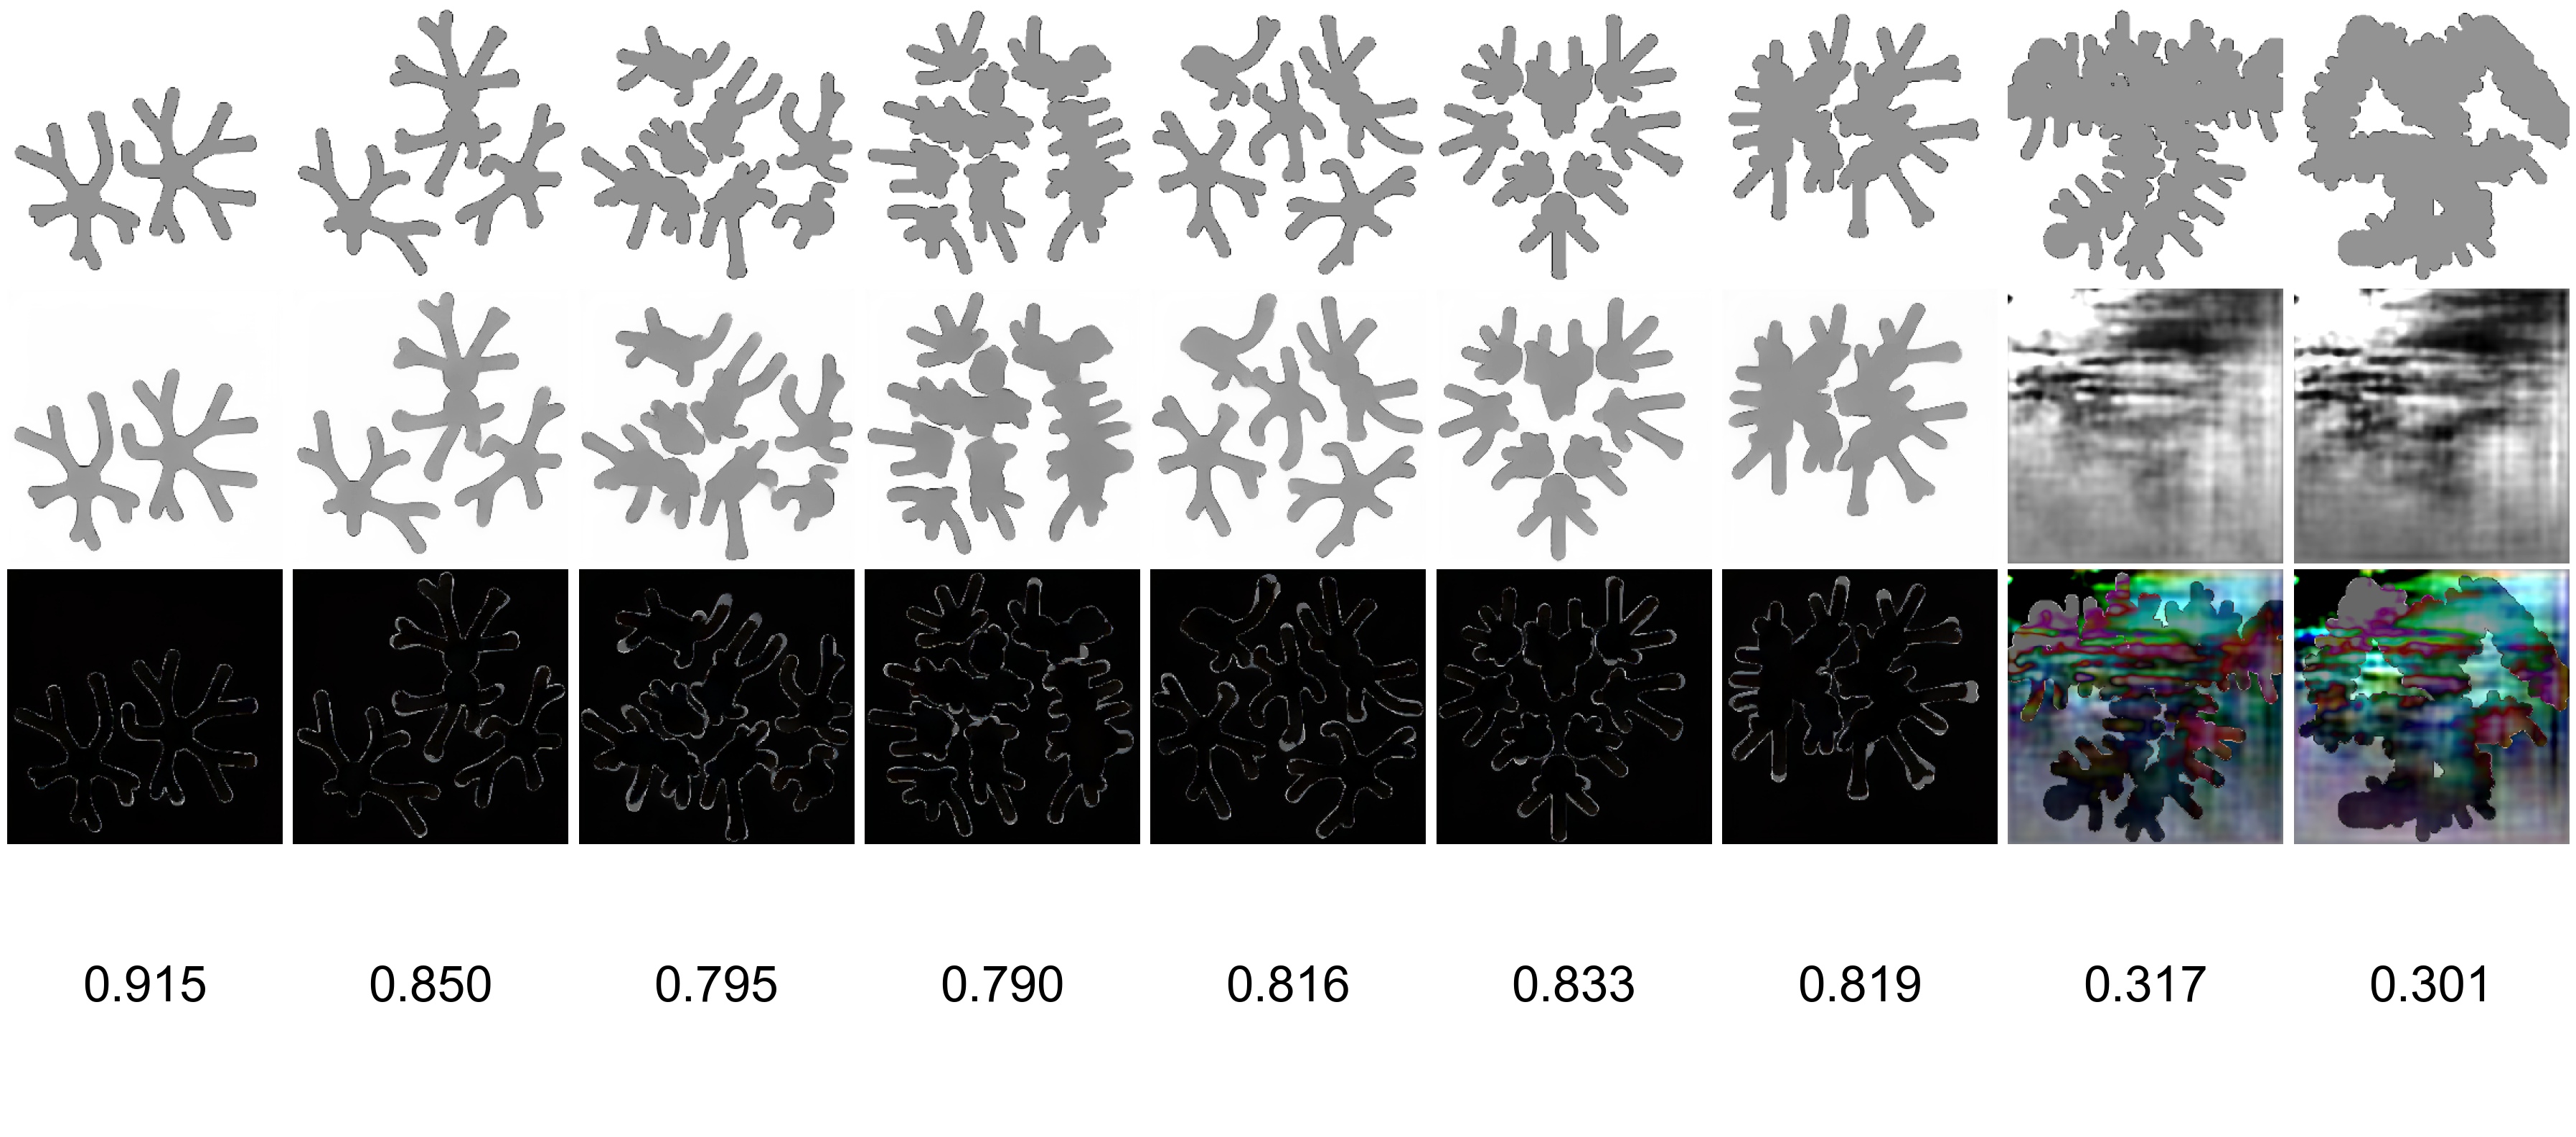

In [6]:
'''
Results include images which have far more seeds than one used in training-> testing generalization and limitations
'''
selected_indices = [14,18,9,10,4,5,2, 6, 7] 

# Assuming X and pred_images are already defined
display_images_with_ssim(X[selected_indices], pred_images[selected_indices], num_samples=9)  

Sample 0: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 5: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 6: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)


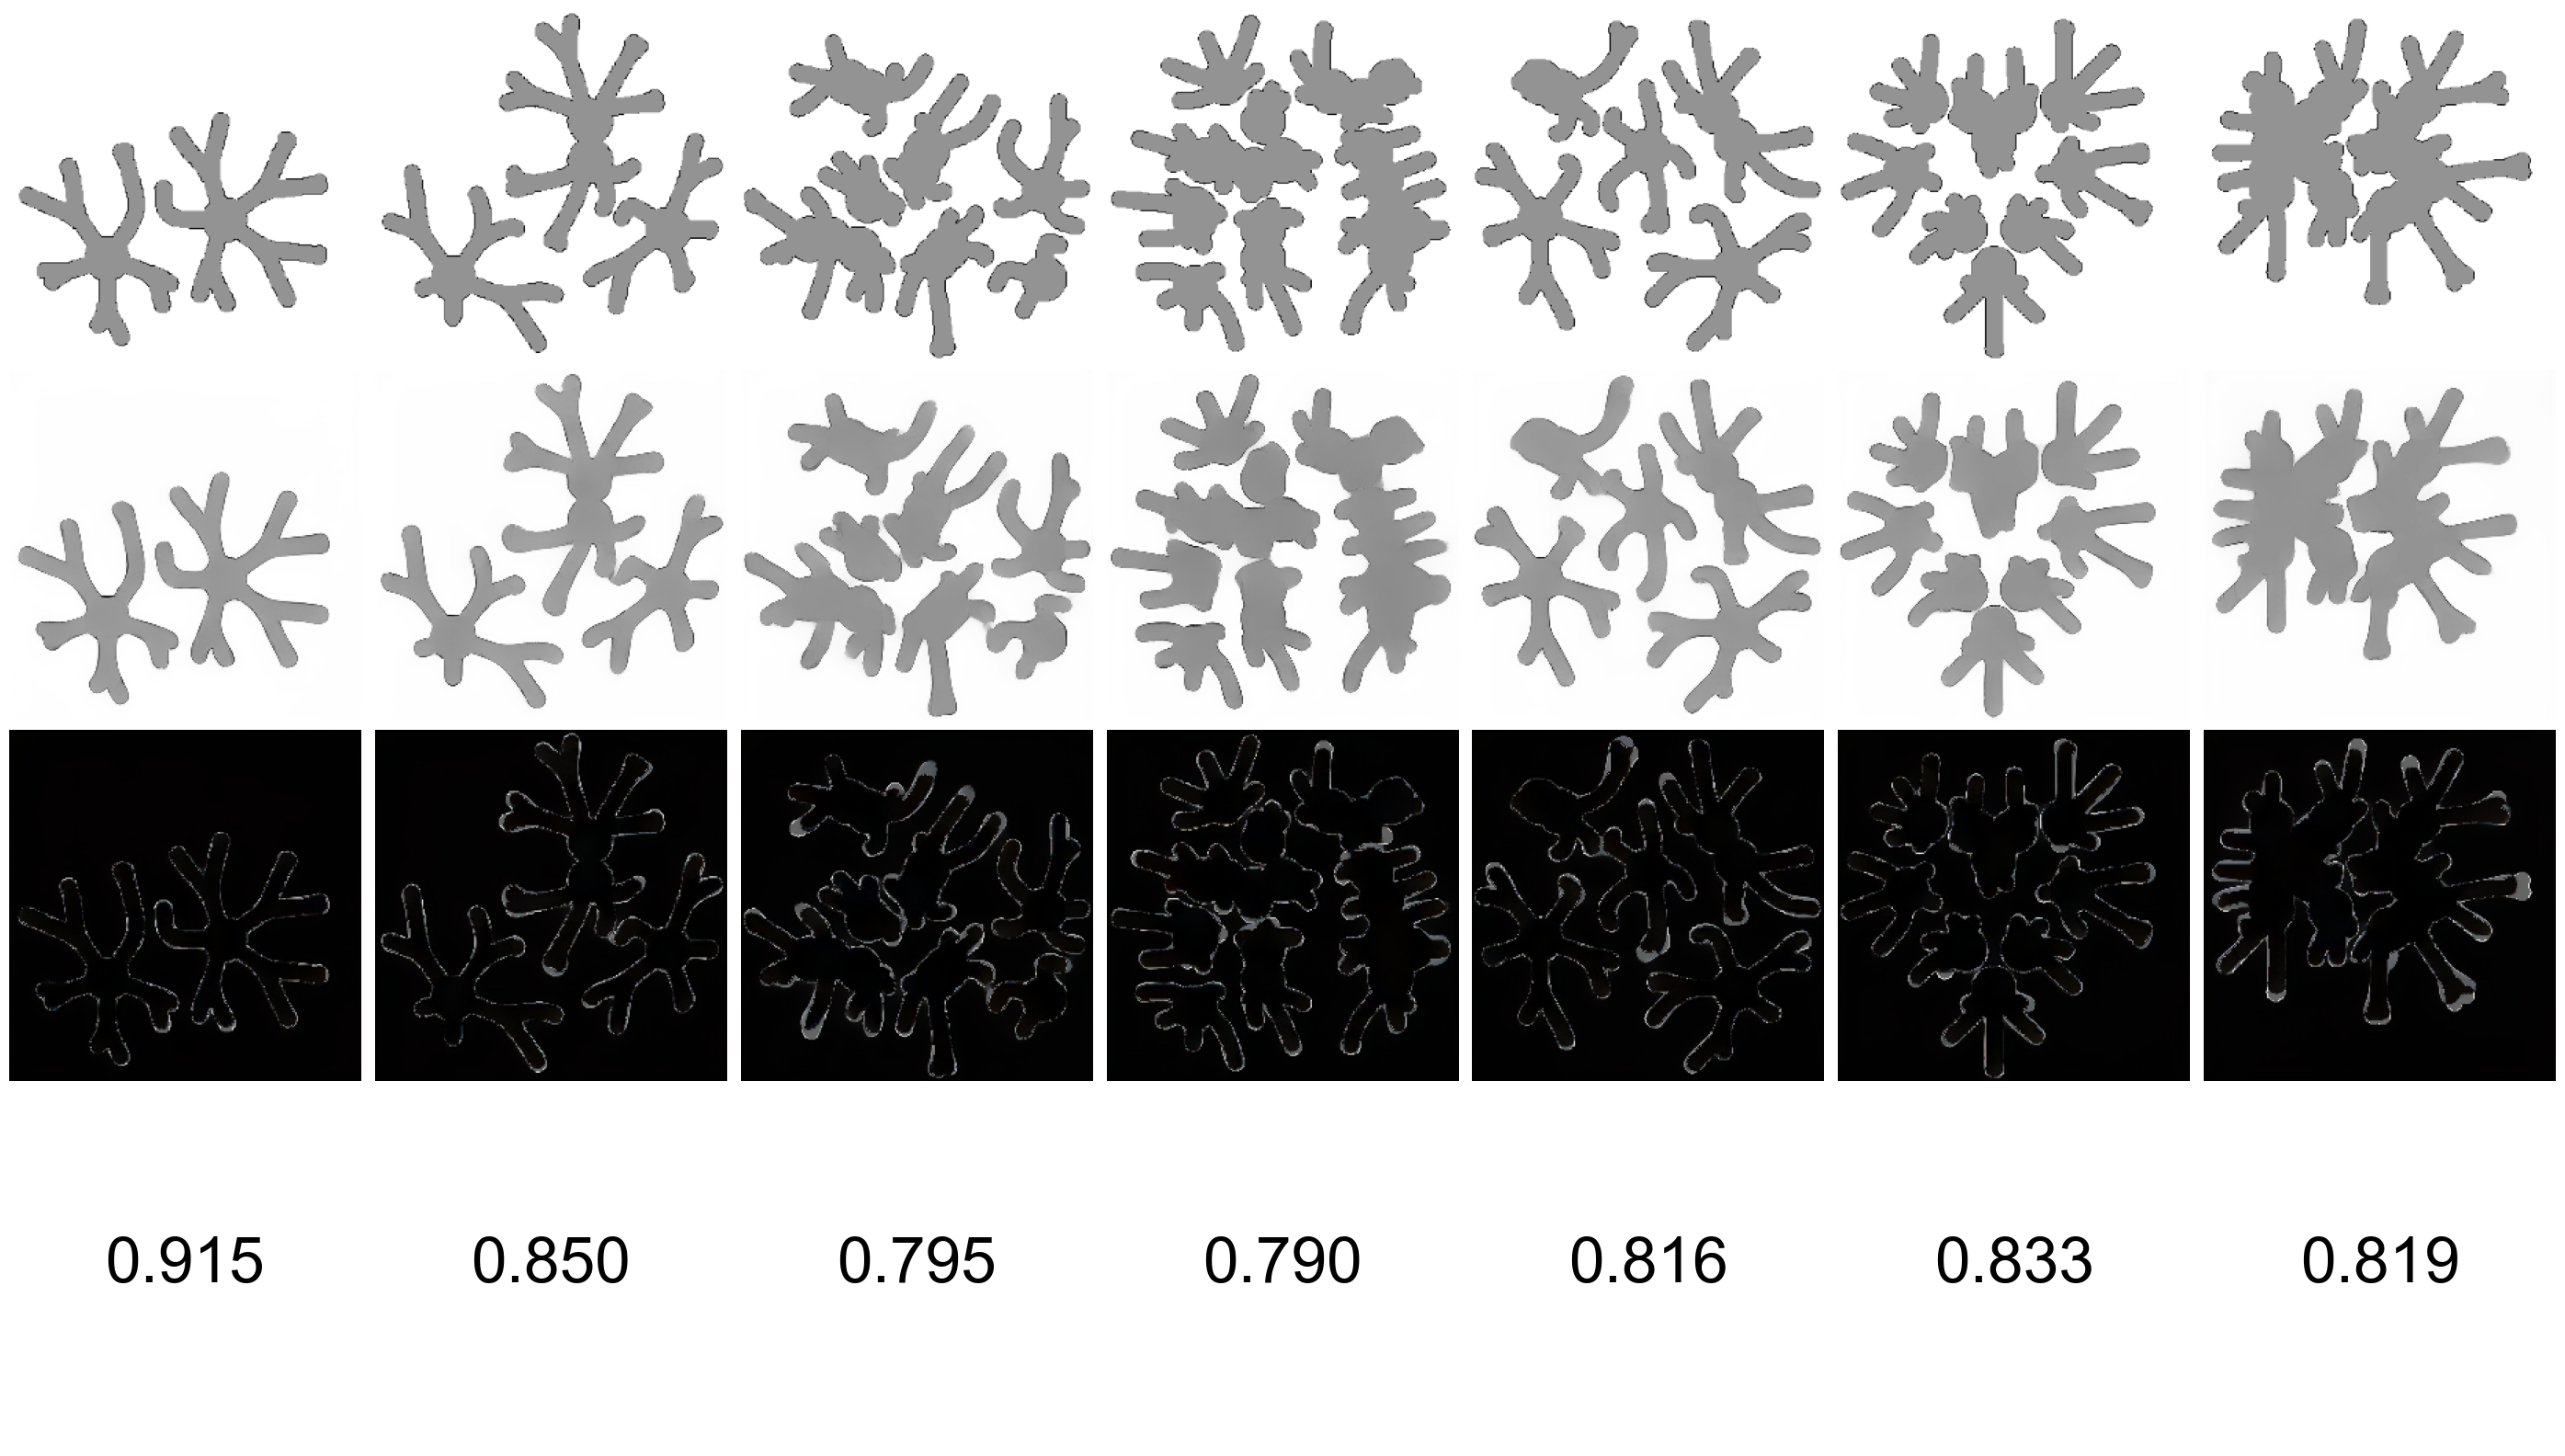

In [7]:
'''
Results represent images that have similar number of seeds as training set, but spatial positioning is different
'''
selected_indices = [14,18,9,10,4,5,2] 

# Assuming X and pred_images are already defined
display_images_with_ssim(X[selected_indices], pred_images[selected_indices], num_samples=7)  #

### The following is for seeing the performance on training/validation images for a baseline of how the network is doing. This is done for now by loading images that are in the training set, and applying the final prediction model on that set. Will have to improve this later like seeing the performance in training by using lightning or tensorboard

In [3]:
"""
Loading input dataset 
"""


input_data=[]
output_data=[]

path_output_2=SIMULATION_TEST_OUTPUT_FOLDER_2
path_input_2=SIMULATION_TEST_INPUT_FOLDER_2

## add some of the images from the main dataset that has been used to train the network

start_index = 0 
end_index = 100
output_data=preprocess_simulation_output_data(path_output_2, start_index, end_index)

# input data
 
input_data=preprocess_simulation_input_data(path_input_2, start_index, end_index)


X=output_data
y=input_data


y=(np.array(y).reshape(-1,1,32,32)) 
X=(np.array(X).reshape(-1,1,256,256))

# normalizing images here to be bw 0 and 1 
y=y/255.0
X=X/255.0 

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

X = torch.Tensor(X)
y = torch.Tensor(y)
y3=y.repeat(1, 3, 1, 1)

In [4]:
"""
Loading desired output datset- simulated patterns (latent embeddings of this)
"""



pickle_in=open(LATENT_OUTPUT_SAVED,"rb")
yprime=pickle.load(pickle_in)


yprime=yprime[:100,:,:,:]


yprime=torch.Tensor(yprime)

yprime_scaled=scale_latents(yprime)
yprime_scaled=yprime_scaled.float()

In [5]:

model = PDEArenaDilatedResNet(
    in_channels=3,               # Input channels 
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:

# load trained model weights
model.load_state_dict(torch.load(MODEL_DILRESNET_FIG2))
model.to(device)

model.eval()
with torch.no_grad():
    predicted_latents=model(y3[:,:,:,:].to(device))  #y3 is the input seed with 3 channels for the UNET 

predicted_latents_rescaled=scale_latents(predicted_latents)

# use the vae decoder to convert the encoded images to final patterns

pred_images=decode_img(predicted_latents)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


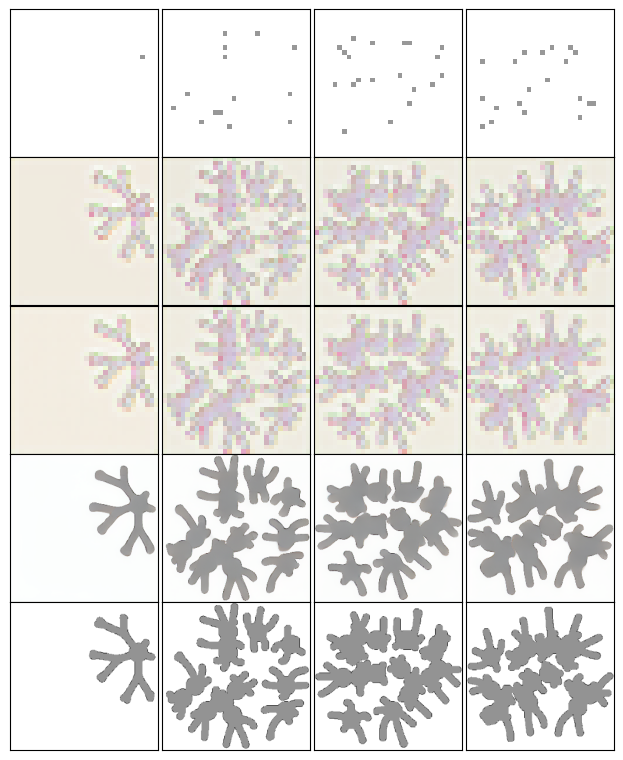

In [13]:

# Display samples from train dataset

display_predicted_images_5X(y3[0:9,:,:,:],yprime_scaled[0:9,:,:,:],predicted_latents_rescaled[0:9,:,:,:],pred_images[0:9,:,:,:],X[0:9,:,:,:] ,4) # 
